In [1]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax

import pandas as pd

In [2]:
# import data from file
file = "code\1-Fragment_C_Hole_Measurements.csv"

df = pd.read_csv(file)

# just extract ID, X,Y values
data_col = df[["Section ID", "Mean(X)", "Mean(Y)"]]

jax_array = jnp.array(data_col)

# First index for ID, second index for X (1) or Y (2)
X = jax_array[:,1]
Y = jax_array[:,2]

data = [X,Y]

In [3]:
# define model

sizes = [1,22,9,37,1,3,2,6] # no. points in each section

# explicitly require separate parameters for xc0,xc1,xc2 etc...
@jax.jit
def modelxy(R,N,xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7,a0,a1,a2,a3,a4,a5,a6,a7):
    
    xc = [xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7]
    yc = [yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7]
    a = [a0,a1,a2,a3,a4,a5,a6,a7]

    # duplicate values of xc, yc, alpha, to make array of length 81 (matching no. points) with values corresponding to each section
    # this is equivalent to iterating over [i] which doesn't work in this JAX-numpyro format

    xc_expand = jnp.array([val for val, count in zip(xc, sizes) for _ in range(count)])
    yc_expand = jnp.array([val for val, count in zip(yc, sizes) for _ in range(count)])
    a_expand = jnp.array([val for val, count in zip(a, sizes) for _ in range(count)])
    
    # index points 1-81 with i = [0,80]
    index = jnp.linspace(0,80,81)

    # phase offset for each point from start of its section
    phi = 2 * jnp.pi * index/N  +  (a_expand * jnp.pi/180) # degrees --> radians

    # model (x,y) coordinates
    xi = (R * jnp.cos(phi) + xc_expand)
    yi = (R * jnp.sin(phi) + yc_expand)
    

    return xi,yi,phi




In [4]:
# jax just-in-time compiler for isotropic likelihood

@jax.jit
def ll_isotropic(params):

    # unpack parameters:
    N,R, a0,a1,a2,a3,a4,a5,a6,a7,sigma, xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7 = params # note sigma_x = sigma_y so just one error parameter

    # unpack data
    X, Y = data

    # extract model xi,yi

    xi, yi, phi = modelxy(R,N,xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7,a0,a1,a2,a3,a4,a5,a6,a7)

    # likelihood on x & y

    x_likelihood = jnp.sum((xi - X)**2 / (2 * sigma**2))
    y_likelihood = jnp.sum((yi - Y)**2 / (2 * sigma**2))

    # prefactor
    norm = len(X) * jnp.log(2 * jnp.pi * sigma * sigma)

    # total likelihood

    likelihood_isotropic = norm + jnp.sum(x_likelihood + y_likelihood)

    return likelihood_isotropic

In [5]:
# jax just-in-time compiler for radial-tangential likelihood

@jax.jit
def ll_aligned(params):

    # unpack parameters:
    N,R, a0,a1,a2,a3,a4,a5,a6,a7,sigma_r, sigma_t, xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7 = params # note sigma_r =! sigma_t ONE MORE ERROR PARAMETER HERE

    # unpack data
    X, Y = data

    # extract model xi,yi

    xi, yi, phi = modelxy(R,N,xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7,a0,a1,a2,a3,a4,a5,a6,a7)

    # determine error between data & model (easier to do before coordinate shift)

    e_x = xi - X 
    e_y = yi - Y

    # project error into radial & tangential directions with coordinate transform depending on phi values
    r_p = e_x * jnp.cos(phi) + e_y * jnp.sin(phi)
    t_p = e_x * jnp.sin(phi) - e_y * jnp.cos(phi)

    # likelihood on radial & tangential components (errors independent so sum is separable)

    r_likelihood = jnp.sum(r_p**2 / (2 * sigma_r**2))
    t_likelihood = jnp.sum(t_p**2 / (2 * sigma_t**2))

    # prefactor
    norm = len(X) * jnp.log(2 * jnp.pi * sigma_r*sigma_t)

    # total likelihood

    likelihood_aligned = norm + r_likelihood + t_likelihood

    return likelihood_aligned



    

In [6]:
# initial guesses CLOSE to final values 

isotropic_pars = [jnp.float32(355.59106),
 jnp.float32(77.41861),
 jnp.float32(-145.97374),
 jnp.float32(-145.6907),
 jnp.float32(-145.62646),
 jnp.float32(-145.49423),
 jnp.float32(-145.02866),
 jnp.float32(-146.24258),
 jnp.float32(-145.21626),
 jnp.float32(-147.69388),
 jnp.float32(0.09445262),
 jnp.float32(79.78643),
 jnp.float32(79.73406),
 jnp.float32(79.93495),
 jnp.float32(79.87209),
 jnp.float32(79.26972),
 jnp.float32(80.849236),
 jnp.float32(80.17723),
 jnp.float32(83.15083),
 jnp.float32(135.93518),
 jnp.float32(136.1171),
 jnp.float32(135.79169),
 jnp.float32(135.78033),
 jnp.float32(135.49957),
 jnp.float32(135.96243),
 jnp.float32(135.39807),
 jnp.float32(136.45322)]
anisotropic_pars = [jnp.float32(355.17987),
 jnp.float32(77.32409),
 jnp.float32(-145.8693),
 jnp.float32(-145.72342),
 jnp.float32(-145.67633),
 jnp.float32(-145.54785),
 jnp.float32(-144.87625),
 jnp.float32(-146.71133),
 jnp.float32(-146.29553),
 jnp.float32(-147.81609),
 jnp.float32(0.028512582),
 jnp.float32(0.1302617),
 jnp.float32(79.623215),
 jnp.float32(79.67909),
 jnp.float32(79.90056),
 jnp.float32(79.85814),
 jnp.float32(79.027725),
 jnp.float32(81.42486),
 jnp.float32(81.47354),
 jnp.float32(83.218414),
 jnp.float32(135.9855),
 jnp.float32(136.02188),
 jnp.float32(135.70462),
 jnp.float32(135.69351),
 jnp.float32(135.36047),
 jnp.float32(136.07745),
 jnp.float32(135.8094),
 jnp.float32(136.40288)]

In [7]:
# ranges on all parameters

N_range = jnp.linspace(340,370,100)

x_range = jnp.linspace(70,90,100)

y_range = jnp.linspace(130,140,100)

alpha_range = jnp.linspace(-150,-140,100)

sigma_range = jnp.linspace(0,1,100)

In [8]:
# finite difference method just for N gradient

N_grad = []
N_values = []

N_grad_numeric = []

# Set a step size for finite differences calculations
eps = 1e-3

for i in range(len(N_range)):

    isotropic_pars_temp = jnp.array(isotropic_pars)
    isotropic_pars_temp = isotropic_pars_temp.at[0].set(N_range[i])

    N_grad.append(jax.grad(ll_isotropic, argnums=0)(isotropic_pars_temp)[0])
    N_values.append(ll_isotropic(isotropic_pars_temp))

    numeric_up = isotropic_pars_temp
    numeric_up = numeric_up.at[0].set(N_range[i] + eps) 

    numeric_down = isotropic_pars_temp
    numeric_down.at[0].set(N_range[i] - eps)

    numeric = (ll_isotropic(numeric_up) - ll_isotropic(numeric_down))/(eps)

    N_grad_numeric.append(numeric)


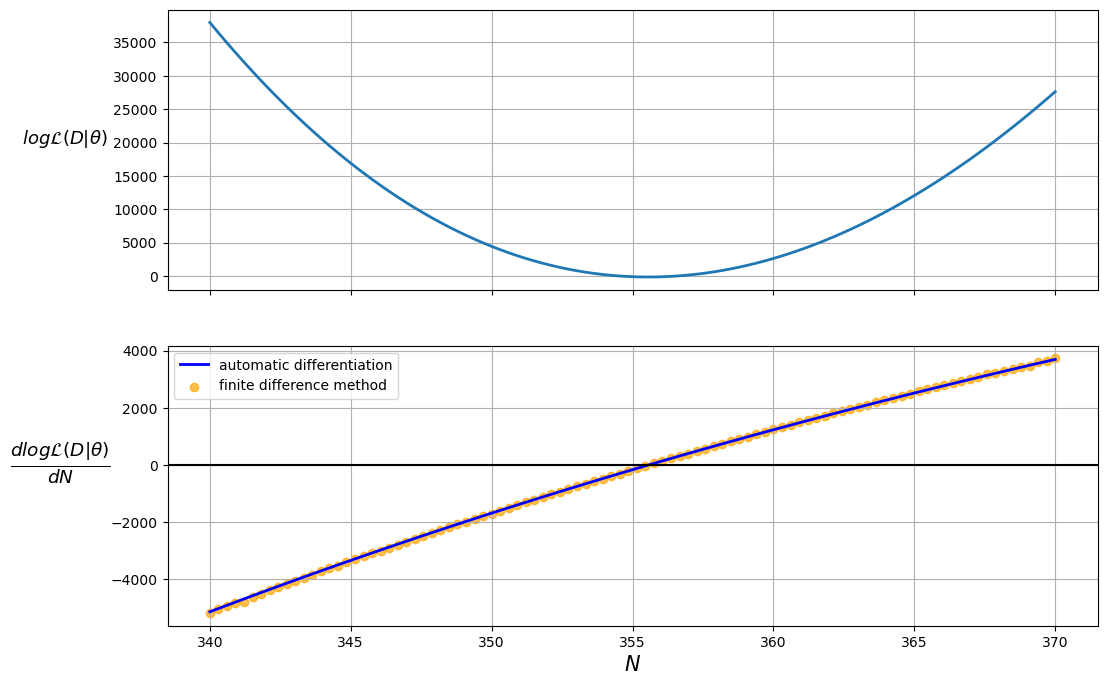

In [9]:
# N parameter and its gradient

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 8))

ax1.plot(N_range, N_values, lw=2)
ax2.plot(N_range, N_grad, lw=2, label='automatic differentiation', color='blue')
ax2.scatter(N_range, N_grad_numeric, label='finite difference method', alpha=0.7, color='orange')

ax1.set_ylabel(r'$log \mathcal{L}(D | \theta )$',
               rotation=0,
               labelpad=35,
               fontsize=13)
ax2.set_ylabel(r'$\frac{dlog \mathcal{L}(D | \theta)}{d N}$ ',
               rotation=0,
               labelpad=35,
               fontsize=19)

ax2.set_xlabel(r'$N$', fontsize=15)
ax1.grid(), ax2.grid()
plt.axhline(c='black')
plt.legend()
plt.show()

/tmp/ipykernel_64201/3472122187.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


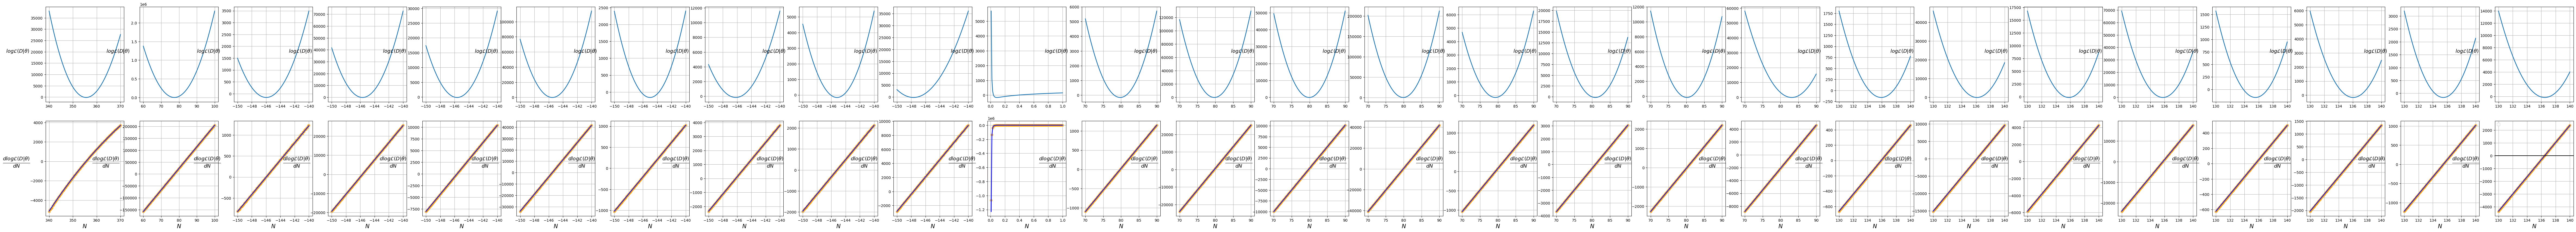

In [10]:
# incredibly dodgy code looping over all parameters

# ranges on all parameters

N_range = jnp.linspace(340,370,100)

R_range = jnp.linspace(60,100,100)

x_range = jnp.linspace(70,90,100)

y_range = jnp.linspace(130,140,100)

alpha_range = jnp.linspace(-150,-140,100)

sigma_range = jnp.linspace(0,1,100)

ranges = (N_range, R_range, alpha_range,alpha_range,alpha_range,alpha_range,alpha_range,alpha_range,alpha_range,alpha_range,sigma_range,x_range,x_range,x_range,x_range,x_range,x_range,x_range,x_range,y_range,y_range,y_range,y_range,y_range,y_range,y_range,y_range)

fig, (ax1, ax2) = plt.subplots(2, len(isotropic_pars), figsize=(120, 10))

# Set a step size for finite differences calculations
eps = 1e-3
for j in range(len(isotropic_pars)):

    grads = []
    grads_numeric = []
    values = []
    
    for i in range(100):

        pars_temp = jnp.array(isotropic_pars)
        pars_temp = pars_temp.at[j].set(ranges[j][i])

        grads.append(jax.grad(ll_isotropic, argnums=0)(pars_temp)[j])
        values.append(ll_isotropic(pars_temp))

        numeric_up = pars_temp
        numeric_up = numeric_up.at[j].set(ranges[j][i] + eps) 

        numeric_down = pars_temp
        numeric_down.at[j].set(ranges[j][i] - eps)

        numeric = (ll_isotropic(numeric_up) - ll_isotropic(numeric_down))/eps

        grads_numeric.append(numeric)


    ax1[j].plot(ranges[j], values, lw=2)
    ax2[j].plot(ranges[j], grads, lw=2, color='blue')
    ax2[j].scatter(ranges[j], grads_numeric, alpha=0.7, color='orange')

    ax1[j].set_ylabel(r'$log \mathcal{L}(D | \theta )$',
                rotation=0,
                labelpad=35,
                fontsize=13)
    ax2[j].set_ylabel(r'$\frac{dlog \mathcal{L}(D | \theta)}{d N}$ ',
                rotation=0,
                labelpad=35,
                fontsize=19)

    ax2[j].set_xlabel(r'$N$', fontsize=15)
    ax1[j].grid(), ax2[j].grid()


    
plt.axhline(c='black')
plt.legend()
plt.show()


In [11]:
# the plot above is silly, reduce parameters


isotropic_pars_reduced = [jnp.float32(355.59106),
 jnp.float32(77.41861),
 jnp.float32(-145.97374),
 jnp.float32(0.09445262),
 jnp.float32(79.78643),
 jnp.float32(135.93518)]
anisotropic_pars_reduced = [jnp.float32(355.17987),
 jnp.float32(77.32409),
 jnp.float32(-145.8693),
 jnp.float32(0.028512582),
 jnp.float32(0.1302617),
 jnp.float32(79.623215),
 jnp.float32(135.9855)]



<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_64201/195715544.py:1: SyntaxWarning: invalid escape sequence '\s'
  labels = ("$N$", "$R$", r"$\alpha_0$", "$\sigma$", r"$x_{c0}$", r"$y_{c0}$" )
/tmp/ipykernel_64201/195715544.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


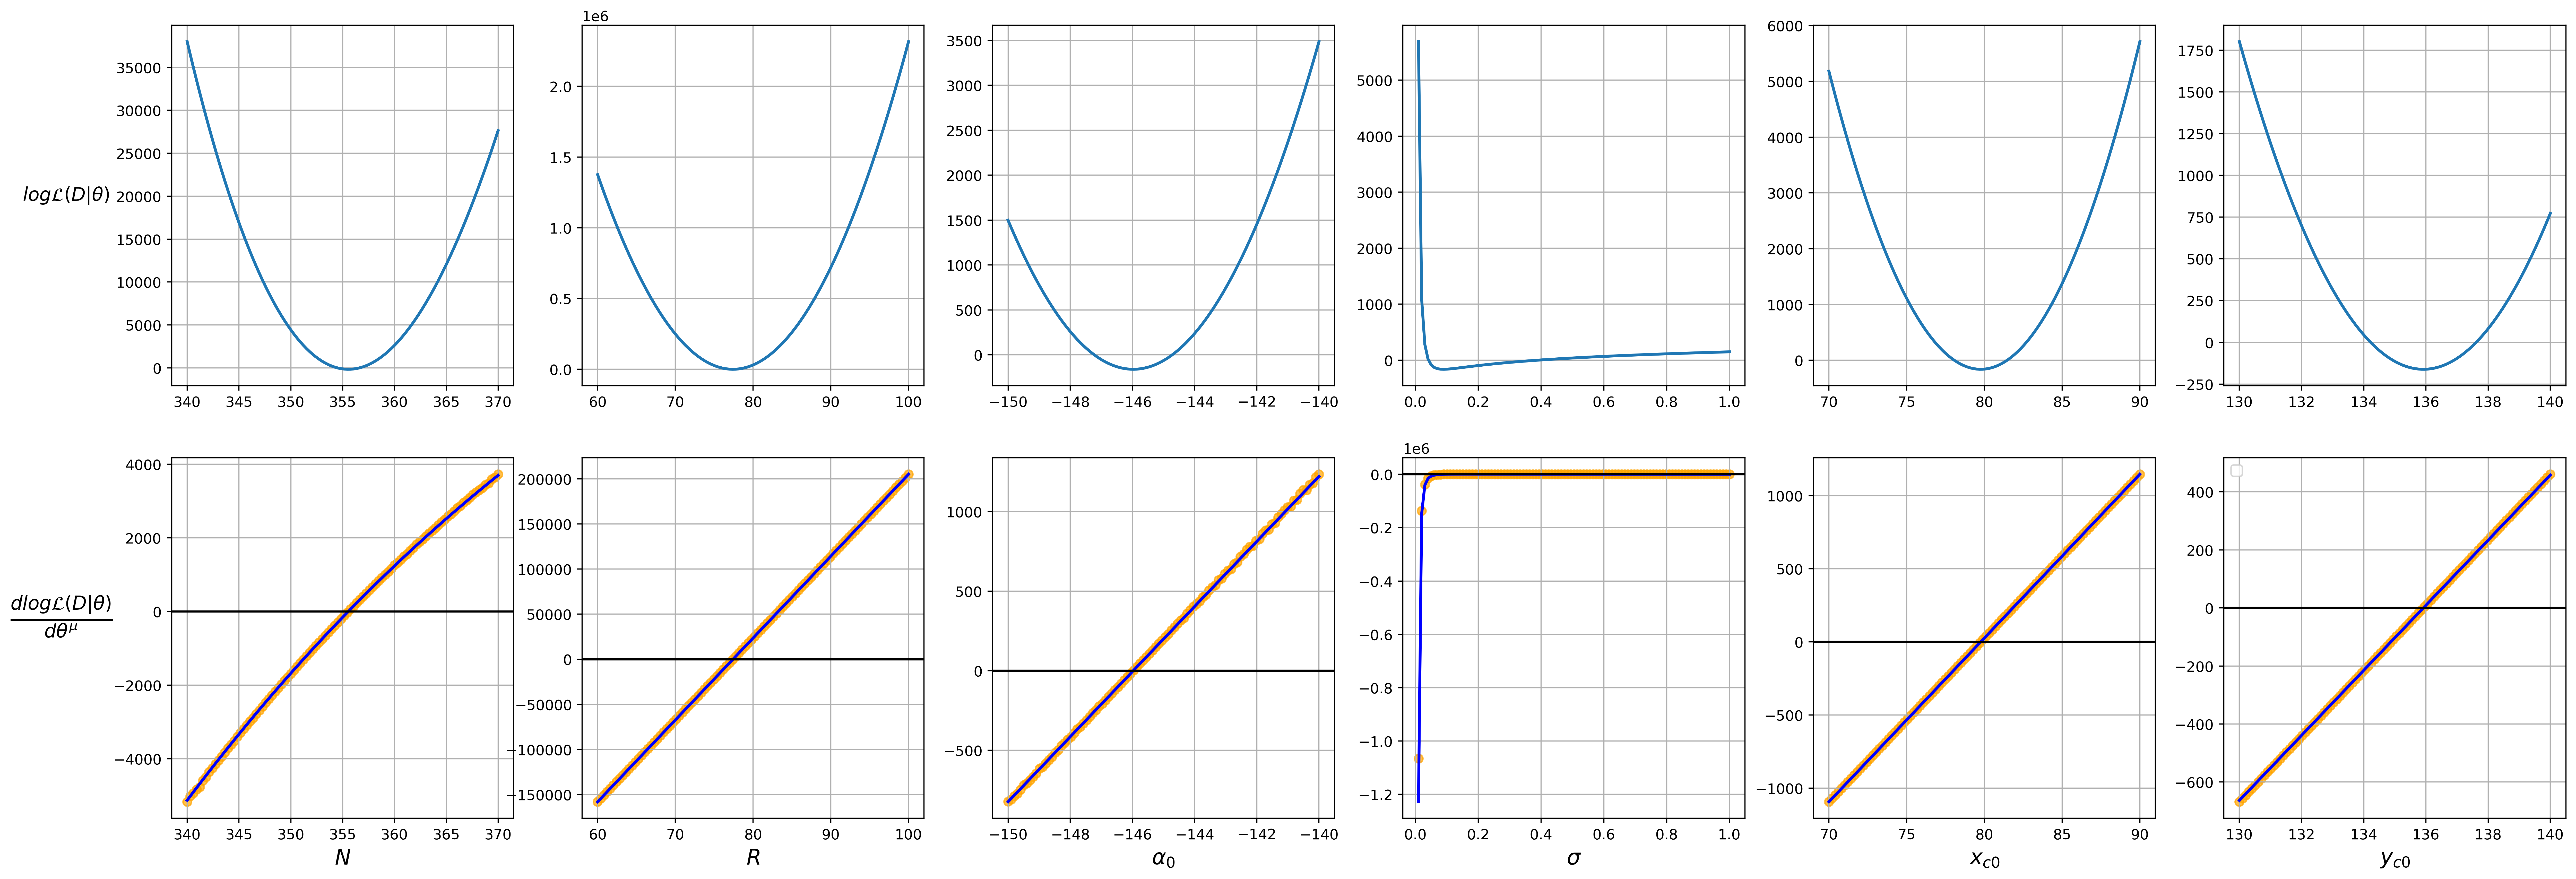

In [12]:
# isotropic model

labels = ("$N$", "$R$", r"$\alpha_0$", "$\sigma$", r"$x_{c0}$", r"$y_{c0}$" )

fig, (ax1, ax2) = plt.subplots(2, len(isotropic_pars_reduced), figsize=(30, 10))

# Set a step size for finite differences calculations
eps = 1e-3

for j in range(len(isotropic_pars_reduced)):

    grads = []
    grads_numeric = []
    values = []
    
    for i in range(100):

        index = (0,1,2,10,11,19)

        pars_temp = jnp.array(isotropic_pars)
        pars_temp = pars_temp.at[index[j]].set(ranges[index[j]][i])

        grads.append(jax.grad(ll_isotropic, argnums=0)(pars_temp)[index[j]])
        values.append(ll_isotropic(pars_temp))

        numeric_up = pars_temp
        numeric_up = numeric_up.at[index[j]].set(ranges[index[j]][i] + eps) 

        numeric_down = pars_temp
        numeric_down.at[index[j]].set(ranges[index[j]][i] - eps)

        numeric = (ll_isotropic(numeric_up) - ll_isotropic(numeric_down))/eps

        grads_numeric.append(numeric)


    ax1[j].plot(ranges[index[j]], values, lw=2)
    ax2[j].plot(ranges[index[j]], grads, lw=2, color='blue')
    ax2[j].scatter(ranges[index[j]], grads_numeric, alpha=0.7, color='orange')

    ax2[j].set_xlabel(labels[j], fontsize=15)
    ax1[j].grid(), ax2[j].grid()
    ax2[j].axhline(c='black')
   

ax1[0].set_ylabel(r'$log \mathcal{L}(D | \theta )$',
            rotation=0,
            labelpad=35,
            fontsize=13)
ax2[0].set_ylabel(r'$\frac{dlog \mathcal{L}(D | \theta)}{d \theta^\mu}$ ',
            rotation=0,
            labelpad=35,
            fontsize=19)
    

fig.set_dpi(400)

plt.show()


<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_64201/3715723471.py:1: SyntaxWarning: invalid escape sequence '\s'
  labels = ("$N$", "$R$", r"$\alpha_0$", "$\sigma_r$", r"$\sigma_t$", r"$x_{c0}$", r"$y_{c0}$" )


error = [25.28833    16.385986   16.76001    20.569336   31.720215   14.091309
 20.409668   15.543457   25.851074    9.360352   15.874512   10.245361
 12.978394   11.397827   14.291748    9.947876   14.967651   17.159546
 13.1085205  13.065063   12.165649   18.703491   14.628784   19.474243
 15.17627     0.76623535 11.151123   11.194824    6.9989014   7.595093
  5.1886597   4.8980713  11.383972    3.0232544   3.395813    2.7349243
  5.4344482   5.166504    0.81134033  5.1601562   2.6889954   4.1586
  1.5073242   0.36401367  1.032074    2.047287    2.9028625   0.6086426
  0.7212372   1.4747467   0.45764327  1.860115    0.2290268   0.40496826
  1.6850891   0.14248657  1.5560913   0.54367065  0.49417114  2.0815735
  3.6264954   5.4701233   5.7349854   4.434204    3.689392    6.187683
 12.539612    3.324463    4.544861    6.9258423   2.1534424   5.6116333
  6.071106   13.042175    8.947266    1.1082764  11.25708     8.37915
  9.554321    9.421631    2.1171875  13.513672   11.869385    8.90

/tmp/ipykernel_64201/3715723471.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


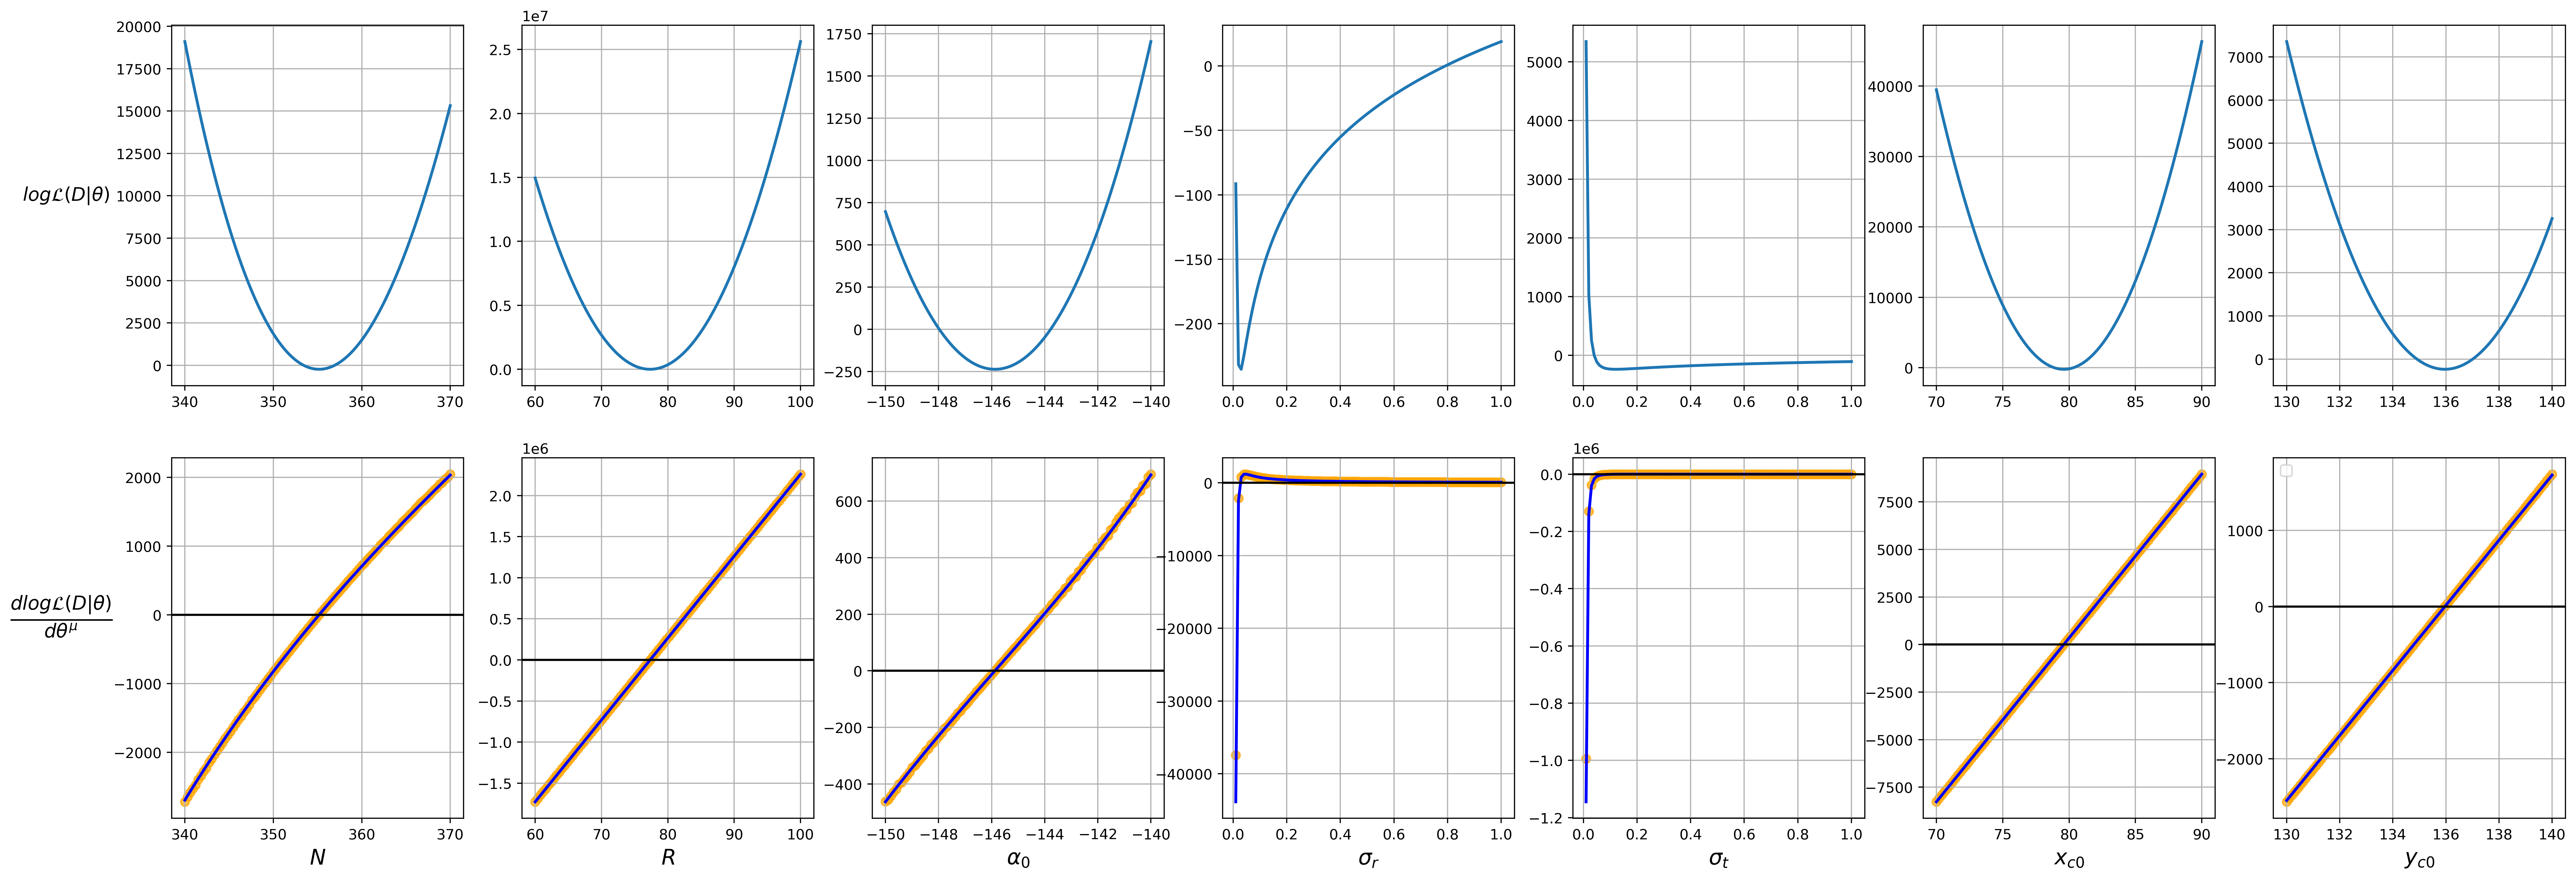

In [ ]:
# radial-tangential model

labels = ("$N$", "$R$", r"$\alpha_0$", "$\sigma_r$", r"$\sigma_t$", r"$x_{c0}$", r"$y_{c0}$" )

fig, (ax1, ax2) = plt.subplots(2, len(anisotropic_pars_reduced), figsize=(30, 10))

ranges = (N_range, R_range, alpha_range,alpha_range,alpha_range,alpha_range,alpha_range,alpha_range,alpha_range,alpha_range,sigma_range,sigma_range,x_range,x_range,x_range,x_range,x_range,x_range,x_range,x_range,y_range,y_range,y_range,y_range,y_range,y_range,y_range,y_range)

# Set a step size for finite differences calculations
eps = 1e-3

for j in range(len(anisotropic_pars_reduced)):

    grads = []
    grads_numeric = []
    values = []
    
    for i in range(100):

        index = (0,1,2,10,11,12,20)

        pars_temp = jnp.array(anisotropic_pars)
        pars_temp = pars_temp.at[index[j]].set(ranges[index[j]][i])

        grads.append(jax.grad(ll_aligned, argnums=0)(pars_temp)[index[j]])
        values.append(ll_aligned(pars_temp))

        numeric_up = pars_temp
        numeric_up = numeric_up.at[index[j]].set(ranges[index[j]][i] + eps) 

        numeric_down = pars_temp
        numeric_down.at[index[j]].set(ranges[index[j]][i] - eps)

        numeric = (ll_aligned(numeric_up) - ll_aligned(numeric_down))/eps

        grads_numeric.append(numeric)


    ax1[j].plot(ranges[index[j]], values, lw=2)
    ax2[j].plot(ranges[index[j]], grads, lw=2, color='blue')
    ax2[j].scatter(ranges[index[j]], grads_numeric, alpha=0.7, color='orange')

    ax2[j].set_xlabel(labels[j], fontsize=15)
    ax1[j].grid(), ax2[j].grid()
    ax2[j].axhline(c='black')
   

ax1[0].set_ylabel(r'$log \mathcal{L}(D | \theta )$',
            rotation=0,
            labelpad=35,
            fontsize=13)
ax2[0].set_ylabel(r'$\frac{dlog \mathcal{L}(D | \theta)}{d \theta^\mu}$ ',
            rotation=0,
            labelpad=35,
            fontsize=19)
    

fig.set_dpi(400)

plt.show()
